In [1]:
import pandas as pd
import numpy as np
import os, itertools
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision.transforms import Lambda
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights

In [3]:
SEEDS = ['100', '200', '300', '400', '500']
pred_dfs = {}
for seed in SEEDS:
    pred_df =  pd.read_csv(f'pred{seed}_df.csv')
    # remove ', [, ] and new line from the string
    pred_df['pred_prob'] = pred_df['pred_prob'].apply(lambda x: str(x).replace(',', '').replace('[', '').replace(']', '').replace('\n', ''))
    # Convert df['pred_prob'] from string to numpy array
    pred_df['pred_prob'] = pred_df['pred_prob'].apply(lambda x: [float(item) for item in x.split(' ')])
    pred_dfs[seed] = pred_df.copy()

In [4]:
subgroups = pred_dfs['100']['fitzpatrick_centaur'].unique()
subgroups.sort()
print(subgroups)

[-1  1  2  3  4  5  6]


In [5]:
ALPHAS = [round(x, 2) for x in np.arange(0.05, 0.55, 0.05)]
print(ALPHAS)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


0.987825334
0.30011536734
0.9994550945


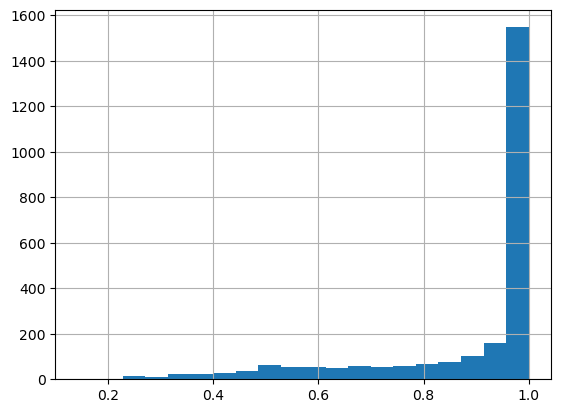

In [6]:
# for each seed, get the pred_prob
# graph the distribution of the pred_prob values
# use matplotlib and plot the distribution of the pred_prob values, where pred_label is equal to label_code


test_df = pred_dfs['100']
test_df['pred_prob_max'] = test_df['pred_prob'].apply(lambda x: max(x))
test_df['pred_prob_max'].hist(bins=20)
# print median, quantiles of pred_prob_max
print(test_df['pred_prob_max'].median())
print(test_df['pred_prob_max'].quantile(0.01))
print(test_df['pred_prob_max'].quantile(0.75))

plt.show()


In [7]:
# conformal prediction set function
# input: quantile, prediction probability set
# output: conformal prediction set
def conformal_prediction_set(quantile, pred_probs):
    # zip the label together with the prediction probability
    # label is from 0 to 113
    labels = list(range(114))
    pred_prob_zip = zip(labels, pred_probs)
    # sort the prediction probability in descending order
    sorted_pred_prob = sorted(pred_prob_zip, key=lambda x: x[1], reverse=True)
    # get the index of the quantile where the cumulative sum of the prediction probability is greater than the quantile
    index = 0
    cum_sum = 0
    while cum_sum < quantile:
        cum_sum += sorted_pred_prob[index][1]
        index += 1
    # get the prediction set labels
    pred_set = [sorted_pred_prob[i][0] for i in range(index)]
    return pred_set 

In [8]:
columns = ['fitzpatrick_scale','fitzpatrick_centaur', 'label', 'label_code', 'nine_partition_label', 'three_partition_label', 'pred_prob', 'pred_label'] 

# Naive conformal prediction set
# Form set by adding elements from sorted softmax scores until cumulative sum exceeds 1 - alpha
naive_dfs = {}
for seed in SEEDS:
    naive_df = pred_dfs[seed].copy()
    naive_df = naive_df[columns]
    for alpha in ALPHAS:
        n = naive_df.shape[0]
        #quantile = float((n+1)*(1-alpha)/n)
        quantile = float(1-alpha)
        naive_df[f'naive_{alpha}'] = naive_df['pred_prob'].apply(lambda x: conformal_prediction_set(quantile, x))
    naive_dfs[seed] = naive_df

In [9]:
# Adaptive Prediction Set(APS) conformal prediction set
# Form set by adding elements from sorted softmax scores until cumulative sum exceeds (n+1)*(1-alpha)/n where n is the number of 
aps_dfs = {}
for seed in SEEDS:
    aps_df = pred_dfs[seed].copy()
    aps_df = aps_df[columns]
    for alpha in ALPHAS:
        n = aps_df.shape[0]
        quantile = float((n+1)*(1-alpha)/n)
        aps_df[f'aps_{alpha}'] = aps_df['pred_prob'].apply(lambda x: conformal_prediction_set(quantile, x))
    aps_dfs[seed] = aps_df

In [10]:
# Marginal coverage
def get_marginal_coverage(labels, prediction_sets):
    k = len(labels)
    correct = 0 
    for label, prediction_set in zip(labels, prediction_sets):
        correct = correct + int(int(label) in prediction_set)
    return correct/k
# Cardinality
def get_cardinality(prediction_sets):
    return np.mean([len(prediction_set) for prediction_set in prediction_sets])
# Subgroup coverage
def subgroup_coverage(df, subgroups, prediction_sets):
    result = {}
    for subgroup in subgroups:
        subgroup_df = df[df['fitzpatrick_scale']==subgroup]
        subgroup_labels = subgroup_df['label_code']
        subgroup_prediction_sets = subgroup_df[prediction_sets]
        result[subgroup] = get_marginal_coverage(subgroup_labels, subgroup_prediction_sets)
    return result
# Subgroup cardinality
def subgroup_cardinality(df, subgroups, prediction_sets):
    result = {}
    for subgroup in subgroups:
        subgroup_df = df[df['fitzpatrick_scale']==subgroup]
        subgroup_prediction_sets = subgroup_df[prediction_sets]
        result[subgroup] = get_cardinality(subgroup_prediction_sets)
    return result

# marginal_coverage(naive_df['label_code'], naive_df['naive_0.5'])
# cardinality(naive_df['naive_0.05'])
# subgroup_coverage(naive_df, naive_df['fitzpatrick_scale'].unique(), 'label_code', 'naive_0.05')
# subgroup_cardinality(naive_df, naive_df['fitzpatrick_scale'].unique(), 'naive_0.05')

In [11]:
def get_diff(res):
    diff = []
    for a, b in itertools.combinations(list(range(len(res))), 2):
        if a == b: continue
        diff.append(abs(res[a] - res[b]))
    return diff

In [12]:
# Coverage disparity
coverage_disparity = {}
for a in ALPHAS:
    print("")
    print('alpha:', a)
    naive_sub_car = {}
    for k, df in naive_dfs.items():
        for sub, cov in subgroup_coverage(df, subgroups, f'naive_{a}').items():
            if sub not in naive_sub_car:
                naive_sub_car[sub] = []
            naive_sub_car[sub].append(cov)
    naive_sub_car = dict(naive_sub_car)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_car))

    aps_sub_car = {}
    for k, df in aps_dfs.items():
        for sub, cov in subgroup_coverage(df, subgroups, f'aps_{a}').items():
            if sub not in aps_sub_car:
                aps_sub_car[sub] = []
            aps_sub_car[sub].append(cov)
    aps_sub_car = dict(aps_sub_car)
    print('aps\t', f(aps_sub_car))
    coverage_disparity[a] = {
        'naive': f(naive_sub_car),
        'aps': f(aps_sub_car)
    }



alpha: 0.05
naive	 (0.043, 0.026)
aps	 (0.043, 0.026)

alpha: 0.1
naive	 (0.041, 0.024)
aps	 (0.041, 0.025)

alpha: 0.15
naive	 (0.042, 0.025)
aps	 (0.042, 0.025)

alpha: 0.2
naive	 (0.041, 0.024)
aps	 (0.041, 0.024)

alpha: 0.25
naive	 (0.041, 0.025)
aps	 (0.041, 0.025)

alpha: 0.3
naive	 (0.041, 0.025)
aps	 (0.041, 0.025)

alpha: 0.35
naive	 (0.042, 0.025)
aps	 (0.042, 0.025)

alpha: 0.4
naive	 (0.041, 0.026)
aps	 (0.041, 0.026)

alpha: 0.45
naive	 (0.042, 0.027)
aps	 (0.042, 0.027)

alpha: 0.5
naive	 (0.042, 0.027)
aps	 (0.042, 0.027)


In [13]:
# Cardinality disparity
cardinality_disparity = {}
for a in ALPHAS:
    print("")
    print('alpha:', a)
    naive_sub_car = {}
    for k, df in naive_dfs.items():
        for sub, cov in subgroup_cardinality(df, subgroups, f'naive_{a}').items():
            if sub not in naive_sub_car:
                naive_sub_car[sub] = []
            naive_sub_car[sub].append(cov)
    naive_sub_car = dict(naive_sub_car)
    g = lambda x: round(np.mean(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    h = lambda x: round(np.std(get_diff(np.array(list(x.values())).mean(1) - 1 - a)), 3)
    f = lambda x: (g(x), h(x))
    print('naive\t', f(naive_sub_car))

    aps_sub_car = {}
    for k, df in aps_dfs.items():
        for sub, cov in subgroup_cardinality(df, subgroups, f'aps_{a}').items():
            if sub not in aps_sub_car:
                aps_sub_car[sub] = []
            aps_sub_car[sub].append(cov)
    aps_sub_car = dict(aps_sub_car)
    print('aps\t', f(aps_sub_car))
    cardinality_disparity[a] = {
        'naive': f(naive_sub_car),
        'aps': f(aps_sub_car)
    }


alpha: 0.05
naive	 (0.397, 0.255)
aps	 (0.398, 0.256)

alpha: 0.1
naive	 (0.241, 0.157)
aps	 (0.242, 0.157)

alpha: 0.15
naive	 (0.171, 0.106)
aps	 (0.171, 0.106)

alpha: 0.2
naive	 (0.129, 0.077)
aps	 (0.129, 0.077)

alpha: 0.25
naive	 (0.102, 0.059)
aps	 (0.102, 0.059)

alpha: 0.3
naive	 (0.081, 0.047)
aps	 (0.081, 0.047)

alpha: 0.35
naive	 (0.067, 0.041)
aps	 (0.067, 0.041)

alpha: 0.4
naive	 (0.053, 0.031)
aps	 (0.053, 0.031)

alpha: 0.45
naive	 (0.041, 0.024)
aps	 (0.041, 0.024)

alpha: 0.5
naive	 (0.035, 0.021)
aps	 (0.035, 0.021)


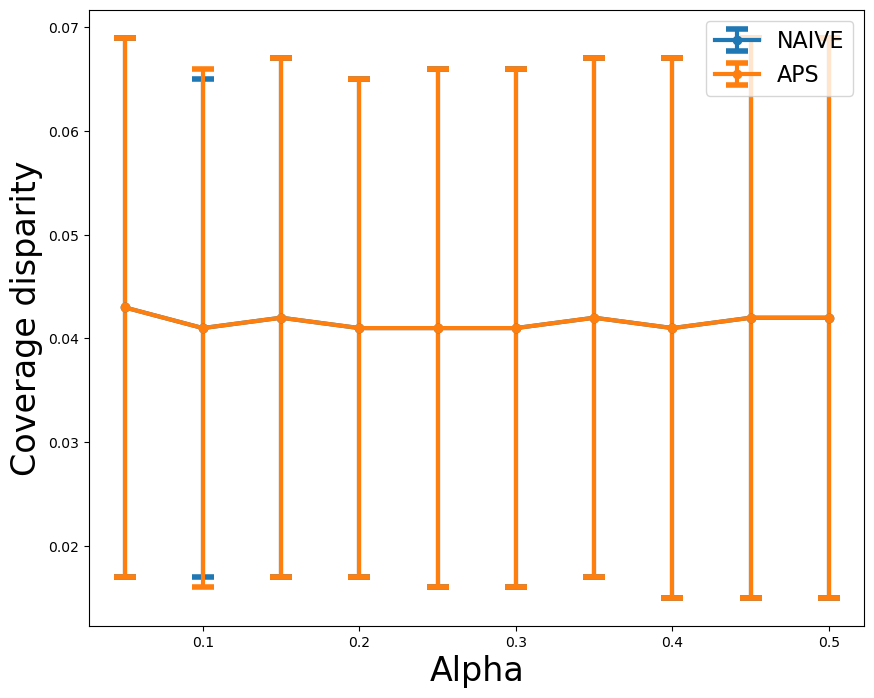

In [14]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Coverage disparity', fontsize=24)

plt.errorbar(
    coverage_disparity.keys(),
    [x['naive'][0] for x in coverage_disparity.values()],
    yerr=[x['naive'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    coverage_disparity.keys(),
    [x['aps'][0] for x in coverage_disparity.values()],
    yerr=[x['aps'][1] for x in coverage_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)

plt.legend(fontsize=16)
plt.show()

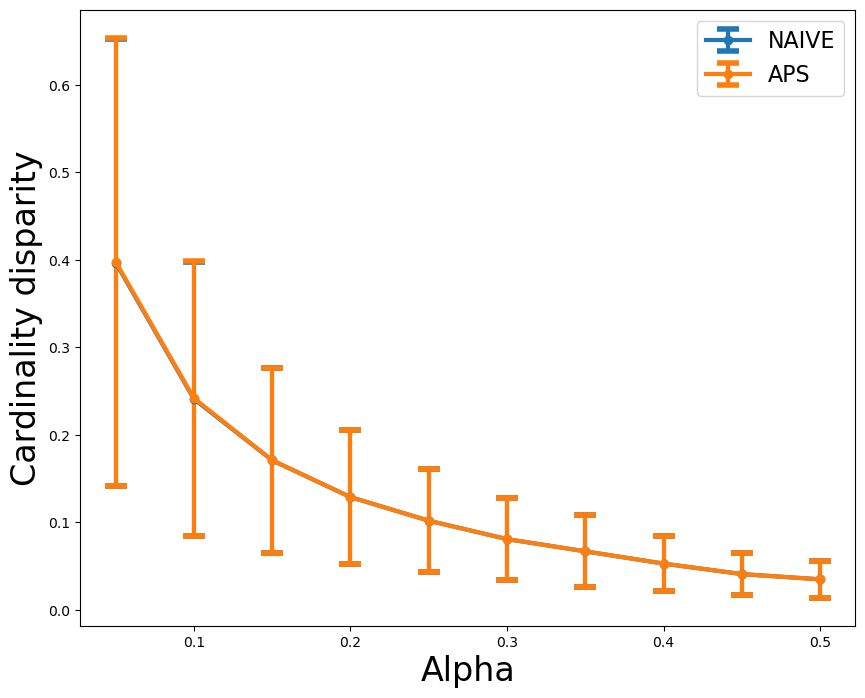

In [249]:
plt.figure(figsize=(10, 8))

plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Alpha', fontsize=24)
plt.ylabel('Cardinality disparity', fontsize=24)

plt.errorbar(
    cardinality_disparity.keys(),
    [x['naive'][0] for x in cardinality_disparity.values()],
    yerr=[x['naive'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='NAIVE',
)
plt.errorbar(
    cardinality_disparity.keys(),
    [x['aps'][0] for x in cardinality_disparity.values()],
    yerr=[x['aps'][1] for x in cardinality_disparity.values()],
    marker='o',
    lw=3,
    capsize=8,
    capthick=4,
    label='APS',
)
plt.legend(fontsize=16)
plt.show()

In [15]:
# Helper functions to aggregate marginal coverage, cardinality, subgroup coverage and subgroup cardinality
def aggregate_coverage(dfs, prefix, alphas=ALPHAS):
    coverage_by_alpha = {}
    for alpha in alphas:
        coverage_by_alpha[alpha] = []
    for seed, df in dfs.items():
        for alpha in alphas:
            labels = [x for x in dfs[seed].label_code.values]
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            coverage_by_alpha[alpha].append(get_marginal_coverage(labels, prediction_sets))
    coverage_by_alpha = dict(coverage_by_alpha)
    alpha, coverage = zip(*coverage_by_alpha.items())
    coverage = np.array(coverage)
    coverage_mean = coverage.mean(1)
    coverage_std = coverage.std(1)
    return alpha, coverage_mean, coverage_std

In [16]:
def aggregate_cardinality(dfs, prefix, alphas=ALPHAS):
    cardinality_by_alpha = {}
    for alpha in alphas:
        cardinality_by_alpha[alpha] = []
    for seed, df in dfs.items():
        for alpha in ALPHAS:
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            cardinality_by_alpha[alpha].append(get_cardinality(prediction_sets))

    cardinality_by_alpha = dict(cardinality_by_alpha)
    alpha, cardinality = zip(*cardinality_by_alpha.items())
    cardinality = np.array(cardinality)
    cardinality_mean = cardinality.mean(1)
    cardinality_std = cardinality.std(1)
    return alpha, cardinality_mean, cardinality_std

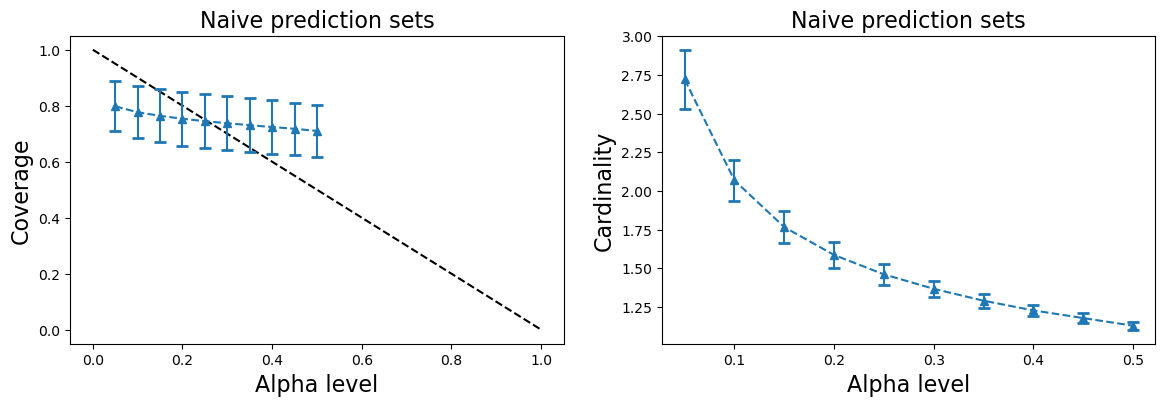

In [17]:
alpha, naive_coverage_mean, naive_coverage_std = aggregate_coverage(naive_dfs, prefix='naive')
alpha, naive_cardinality_mean, naive_cardinality_std = aggregate_cardinality(naive_dfs, prefix='naive')
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].set_title('Naive prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('Naive prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

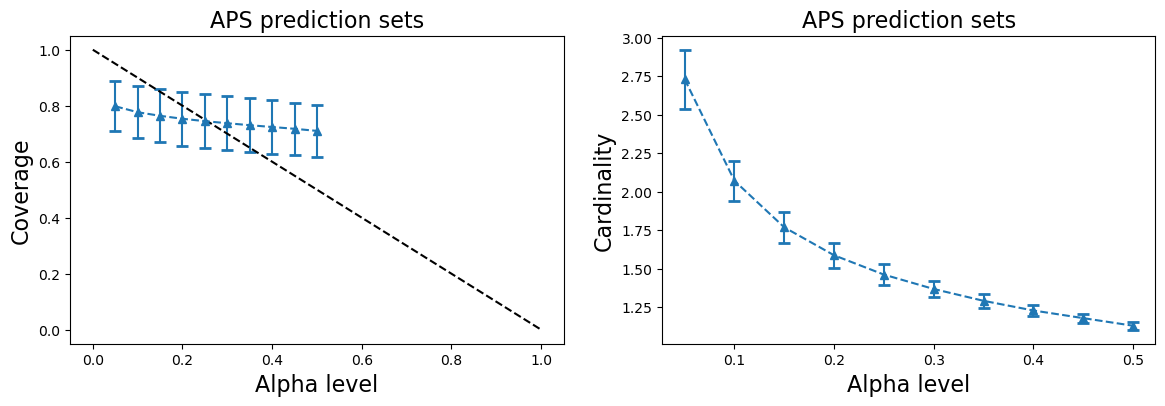

In [209]:
alpha, aps_coverage_mean, aps_coverage_std = aggregate_coverage(aps_dfs, prefix='aps')
alpha, aps_cardinality_mean, aps_cardinality_std = aggregate_cardinality(aps_dfs, prefix='aps')
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('APS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('APS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

In [ ]:
# Regularized adaptive prediction set (RAPS)
# Parameterized regulaization penality lambda (L) and K
K_REG = 0
LAMBDA = 1e-4

penalty = np.zeros((1, 114))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

def sort_sum(scores):
    scores = np.array(scores)
    index = scores.argsort()
    ordered = np.sort(scores)
    cumsum = np.cumsum(ordered)
    return index, ordered, cumsum

def raps_calibrate(
        scores,
        labels, 
        index, 
        ordered, 
        cumsum, 
        penalty, 
        randomized, 
        allow_zero_sets,
        alpha=0.05,
    ):
    def get_p_value(
            score, 
            label, 
            index, 
            ordered, 
            cumsum, 
            penalty, 
            randomized, 
            allow_zero_sets
        ):
        idx = np.where(index == label)
        tau = cumsum[idx]

        if not randomized:
            return tau + penalty[0]

        e = np.random.random()
        if idx == (0, 0):
            return penalty[0] + (e * tau if allow_zero_sets else tau)
        else:
            p = penalty[0:(idx[1][0] + 1)].sum()
            return p + cumsum[(idx[0], idx[1] - 1)] + (e * ordered[idx])

    mask = -np.ones(scores.shape[0])
    for i in range(mask.shape[0]):
        mask[i] = get_p_value(
        scores[i,:],
        labels[i].item(),
        index[None, i,:],
        ordered[None, i,:],
        cumsum[None, i,:],
        penalty[0, :],
        randomized=True,
        allow_zero_sets=False
    )

    qhat = np.quantile(mask, 1 - alpha, interpolation='higher')
    return qhat
scores = pred_df['pred_prob']
labels = pred_df['label_code']
index, ordered, cumsum = sort_sum(scores)
qhat = raps_calibrate(
            scores, labels, index, ordered, cumsum,
            penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
        )

In [24]:
# Malignant labels
malignant_conditions = {}
sample_df = naive_dfs['100']
maglinant_codes = sample_df.loc[sample_df['three_partition_label']=='malignant', 'label_code'].unique()
for code in maglinant_codes:
    malignant_conditions[code] = naive_dfs['100'].loc[naive_dfs['100'].label_code == code].label.values[0]
# rule in
def rule_in(df, prediction_sets, malignant_conditions=malignant_conditions.keys()):
    total = 0
    correct = 0
    for index, row in df.iterrows():
        prediction_set = row[prediction_sets]
        if row['label_code'] in malignant_conditions:
            total += 1
            if row['label_code'] in prediction_set:
                correct += 1
    return correct / total

# rule out 
def rule_out(df, prediction_sets, malignant_conditions=malignant_conditions.keys()):
    total = 0
    correct = 0
    for index, row in df.iterrows():
        prediction_set = row[prediction_sets]
        if row['label_code'] not in malignant_conditions:
            total += 1
            # if prediction_set and maglinant_conditions do not have any shared element
            if not set(prediction_set).intersection(malignant_conditions):
                correct += 1
    return correct / total

In [25]:
naive_rule_in = {}
aps_rule_in = {}

naive_rule_out = {}
aps_rule_out = {}

naive_crit_set_size = {}
aps_crit_set_size = {}

naive_non_crit_set_size = {}
aps_non_crit_set_size = {}

for alpha in ALPHAS:
    for seed in SEEDS:
        naive_df = naive_dfs[seed]
        naive_rule_in[alpha] = []
        naive_rule_out[alpha] = []
        naive_crit_set_size[alpha] = []
        naive_non_crit_set_size[alpha] = []
        naive_crit_df = naive_df[naive_df.label_code.isin(malignant_conditions)]
        naive_non_crit_df = naive_df[~naive_df.label_code.isin(malignant_conditions)]

        aps_df = aps_dfs[seed]
        aps_rule_in[alpha] = []
        aps_rule_out[alpha] = []
        aps_crit_set_size[alpha] = []
        aps_non_crit_set_size[alpha] = []
        aps_crit_df = aps_df[aps_df.label_code.isin(malignant_conditions)]
        aps_non_crit_df = aps_df[~aps_df.label_code.isin(malignant_conditions)]

        naive_rule_in[alpha].append(rule_in(naive_crit_df, f'naive_{alpha}'))
        aps_rule_in[alpha].append(rule_in(aps_crit_df, f'aps_{alpha}'))
        
        naive_crit_set_size[alpha].append(naive_crit_df[f'naive_{alpha}'].apply(len).mean())
        aps_crit_set_size[alpha].append(aps_crit_df[f'aps_{alpha}'].apply(len).mean())


        naive_rule_out[alpha].append(rule_out(naive_non_crit_df, f'naive_{alpha}'))
        aps_rule_out[alpha].append(rule_out(aps_non_crit_df, f'aps_{alpha}'))

        
        naive_non_crit_set_size[alpha].append(naive_non_crit_df[f'naive_{alpha}'].apply(len).mean())
        aps_non_crit_set_size[alpha].append(aps_non_crit_df[f'aps_{alpha}'].apply(len).mean())



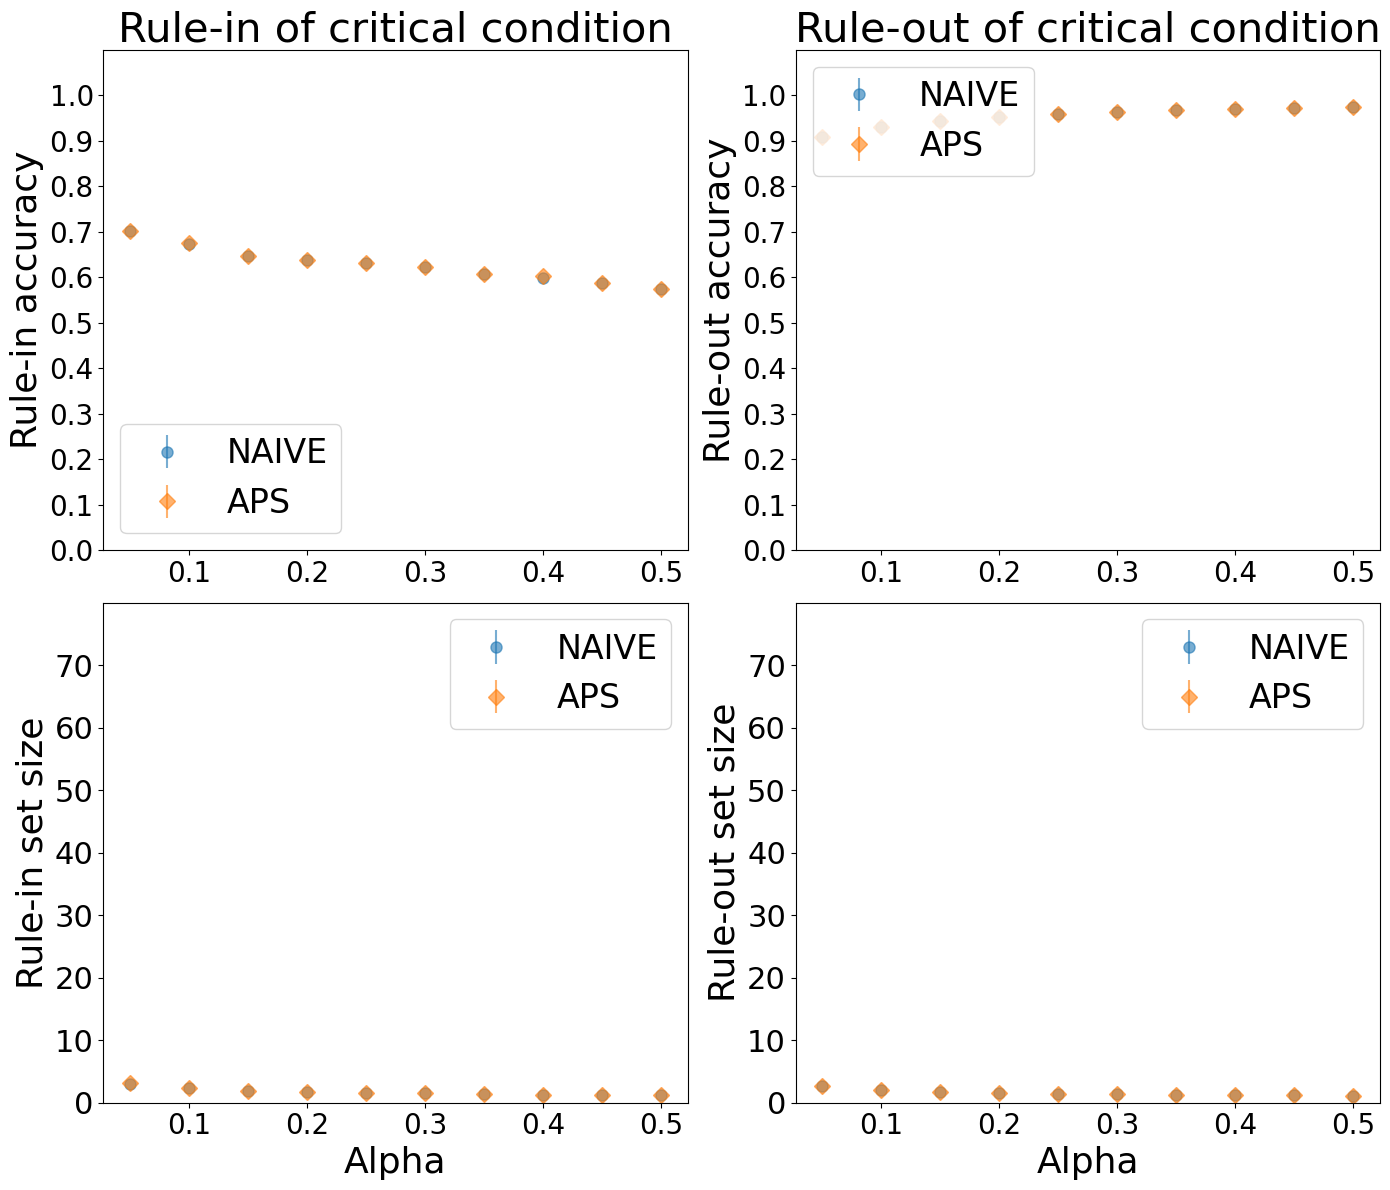

In [26]:
markersize=8
fontsize=26
alpha=0.8
fmt1='o'
fmt2='X'
fmt3='D'

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14, 12)

ax[0, 0].set_title('Rule-in of critical condition', fontsize=fontsize + 4)
# ax[0, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 0].set_ylabel('Rule-in accuracy', fontsize=fontsize)
ax[0, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 0].set_ylim(0, 1.1)

ax[0, 1].set_title('Rule-out of critical condition', fontsize=fontsize + 4)
# ax[0, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[0, 1].set_ylabel('Rule-out accuracy', fontsize=fontsize)
ax[0, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[0, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_yticklabels([round(y, 1) for y in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[0, 1].set_ylim(0, 1.1)

# ax[1, 0].set_title('Rule-in', fontsize=fontsize + 4)
ax[1, 0].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 0].set_ylabel('Rule-in set size', fontsize=fontsize)
ax[1, 0].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 0].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 0].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 0].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 0].set_ylim(0, 80)

# ax[1, 1].set_title('Rule-out', fontsize=fontsize + 4)
ax[1, 1].set_xlabel('Alpha', fontsize=fontsize)
ax[1, 1].set_ylabel('Rule-out set size', fontsize=fontsize)
ax[1, 1].set_xticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
ax[1, 1].set_yticks(range(0, 80, 10), fontsize=fontsize)
ax[1, 1].set_xticklabels([round(x, 1) for x in np.arange(0, 1.1, 0.1)], fontsize=fontsize-6)
ax[1, 1].set_yticklabels(range(0, 80, 10), fontsize=fontsize-4)
ax[1, 1].set_ylim(0, 80)

naive = np.array(list(naive_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_in.values()))
ax[0, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)

ax[0, 0].legend(fontsize=fontsize-2, loc='lower left')

naive = np.array(list(naive_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_rule_out.values()))
ax[0, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)

ax[0, 1].legend(fontsize=fontsize-2, loc='upper left')

naive = np.array(list(naive_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_crit_set_size.values()))
ax[1, 0].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)

ax[1, 0].legend(fontsize=fontsize-2, loc='upper right')

naive = np.array(list(naive_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, naive.mean(1), naive.std(1),
    fmt=fmt1, color='C0', markersize=markersize,
    label='NAIVE', alpha=alpha - 0.2,
)
aps = np.array(list(aps_non_crit_set_size.values()))
ax[1, 1].errorbar(
    ALPHAS, aps.mean(1), aps.std(1),
    fmt=fmt3, color='C1', markersize=markersize,
    label='APS', alpha=alpha - 0.2,
)

ax[1, 1].legend(fontsize=fontsize -2, loc='upper right')

plt.tight_layout()

plt.show()

In [2]:
import matplotlib
matplotlib.__version__

'3.5.1'